In [65]:
!pip install xgboost lightgbm catboost scikit-learn


In [66]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [67]:
data = pd.read_csv('D:/project/csv/application_record.csv', encoding = 'utf-8')
record = pd.read_csv('D:/project/csv/credit_record.csv', encoding = 'utf-8')

In [68]:
begin_month = pd.DataFrame(record.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE' : 'begin_month'})
new_data = pd.merge(data, begin_month, how='left', on='ID')

In [69]:
new_data.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
begin_month            402100
dtype: int64

In [70]:
# Tạo dep_value dựa trên STATUS
record['dep_value'] = record['STATUS'].isin(['2','3','4','5']).map({True: 'Yes', False: None})

# # Group by và count
cpunt = record.groupby('ID').count()
cpunt['dep_value'] = (cpunt['dep_value'] > 0).map({True: 'Yes', False: 'No'})
cpunt = cpunt[['dep_value']]

# Merge và tạo target
new_data = pd.merge(new_data, cpunt, how='inner', on='ID')
new_data['target'] = (new_data['dep_value'] == 'Yes').astype(int)

# In kết quả
print(cpunt['dep_value'].value_counts())
print(cpunt['dep_value'].value_counts(normalize=True))



dep_value
No     45318
Yes      667
Name: count, dtype: int64
dep_value
No     0.985495
Yes    0.014505
Name: proportion, dtype: float64


In [71]:
new_data.rename(columns={'CODE_GENDER':'Gender',
                         'FLAG_OWN_CAR':'Car',
                         'FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo',
                         'AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp',
                         'NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp',
                         'FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp',
                         'FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone',
                         'CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [72]:
new_data.isnull().sum()

ID                   0
Gender               0
Car                  0
Reality              0
ChldNo               0
inc                  0
inctp                0
edutp                0
famtp                0
houtp                0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
wkphone              0
phone                0
email                0
occyp            11323
famsize              0
begin_month          0
dep_value            0
target               0
dtype: int64

In [73]:
new_data.dropna()
new_data = new_data.mask(new_data == "NULL").dropna()

In [74]:
ivtable = pd.DataFrame(new_data.columns, columns=['variable'])
ivtable['IV'] = None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

In [75]:
ivtable.isnull().sum()

variable     0
IV          16
dtype: int64

In [76]:
new_data.isnull().sum()

ID               0
Gender           0
Car              0
Reality          0
ChldNo           0
inc              0
inctp            0
edutp            0
famtp            0
houtp            0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
wkphone          0
phone            0
email            0
occyp            0
famsize          0
begin_month      0
dep_value        0
target           0
dtype: int64

In [77]:
# tính woe và iv cho từng biến
# return bảng woe/iv và tổng iv
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [78]:
# Chuyển biến phân loại thành dummy variables, loại bỏ nhóm có tần suất cao nhất để tránh multicollinearity.
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [79]:
#Chia biến liên tục thành nhóm:
# qcut=True: Chia theo quantile
# qcut=False: Chia theo độ dài bằng nhau
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [80]:
#vẽ confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
#Binary feature

In [82]:
new_data['Gender'] = new_data['Gender'].replace(['F', 'M'], [0, 1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

Gender
0    15630
1     9504
Name: count, dtype: int64
This variable's IV is: 0.02520350452745081
Gender
0    15630
1     9504
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


In [83]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

Car
0    14618
1    10516
Name: count, dtype: int64
This variable's IV is: 4.54248124999671e-06
Car
0    14618
1    10516
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


In [84]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

Reality
1    16461
0     8673
Name: count, dtype: int64
This variable's IV is: 0.02744070350168343
Reality
1    16461
0     8673
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


In [85]:
new_data.isna().sum()

ID               0
Gender           0
Car              0
Reality          0
ChldNo           0
inc              0
inctp            0
edutp            0
famtp            0
houtp            0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
wkphone          0
phone            0
email            0
occyp            0
famsize          0
begin_month      0
dep_value        0
target           0
dtype: int64

In [86]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

phone
0    0.707209
1    0.292791
Name: proportion, dtype: float64
This variable's IV is: 0.0005480495762639297
phone
0    17775
1     7359
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


In [87]:
new_data['email'] = new_data['email'].astype(str)
print(new_data['email'].value_counts(normalize=True, sort=False))
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

email
0    0.89934
1    0.10066
Name: proportion, dtype: float64
This variable's IV is: 1.7343581493999816e-05
email
0    22604
1     2530
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


In [88]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
wkphone
0    18252
1     6882
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


In [89]:
#Continuous Features

In [90]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

ChldNo
0        15908
2More     3108
1         6118
Name: count, dtype: int64


In [91]:


iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
ChldNo
0        15908
1         6118
2More     3108
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [92]:
new_data = convert_dummy(new_data,'ChldNo')

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

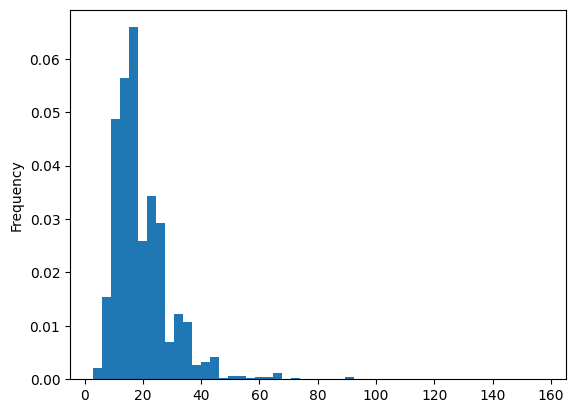

In [93]:
#income
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [94]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0024219962221596752
gp_inc
low       8996
high      8244
medium    7894
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [95]:
new_data = convert_dummy(new_data,'gp_inc')

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: proportion, dtype: float64


<Axes: ylabel='Frequency'>

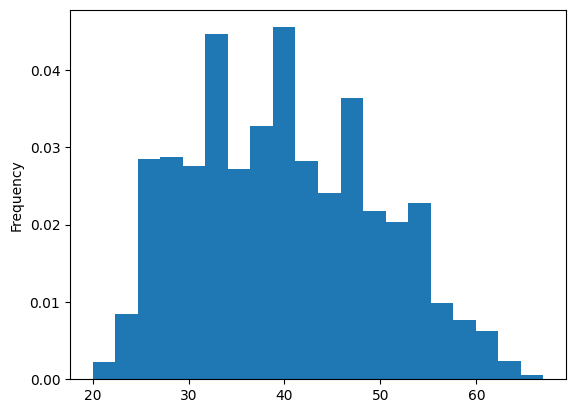

In [96]:
#Age
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [97]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
gp_Age
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [98]:
new_data = convert_dummy(new_data,'gp_Age')

<Axes: ylabel='Frequency'>

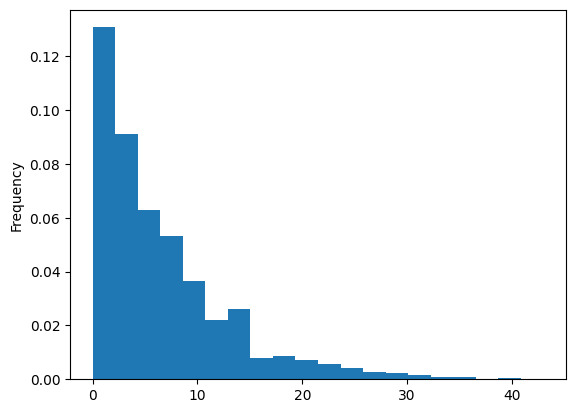

In [99]:
#day work
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [100]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
gp_worktm
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [101]:
new_data = convert_dummy(new_data,'gp_worktm')

In [102]:
#number of family member 
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
famsizegp
2        12697
3more     8174
1         4263
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [103]:
new_data = convert_dummy(new_data,'famsizegp')

In [104]:
#Categorical Features

In [105]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

inctp
Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: count, dtype: int64
inctp
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: proportion, dtype: float64
This variable's IV is: 5.159303327851404e-05
inctp
Working                 15622
Commercial associate     7052
State servant            2460
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [106]:
new_data = convert_dummy(new_data,'inctp')

In [107]:
#occupation (nghe nghiep)
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()   

occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64
This variable's IV is: 0.004820472062853304
occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [108]:
new_data = convert_dummy(new_data,'occyp')

In [109]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
houtp
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [110]:
new_data = convert_dummy(new_data,'houtp')

In [111]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
edutp
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [112]:
new_data = convert_dummy(new_data,'edutp')


In [113]:
#marriage
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
famtp
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [114]:
new_data = convert_dummy(new_data,'famtp')

In [115]:
#tính iv và woe

In [116]:
#sắp xếp ivtable theo thứ tự quan trọng
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


In [118]:
#Splitting data

In [119]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

Text(0.5, 1.0, 'Class Distributions \n (0: No || 1: Yes)')

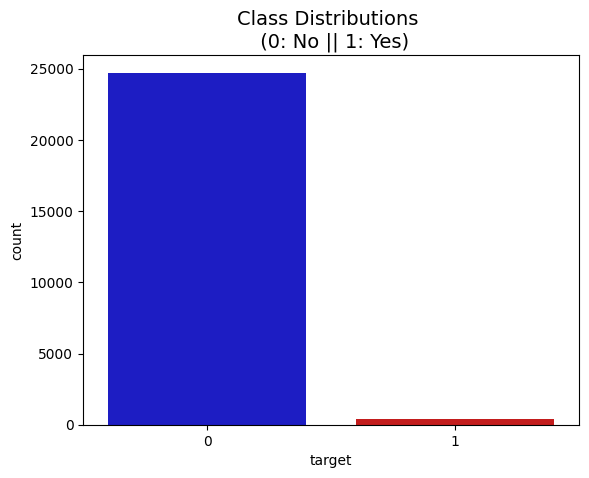

In [120]:
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='target', data = new_data, palette=colors)
plt.title('Class Distributions \n (0: No || 1: Yes)', fontsize = 14)

In [121]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Text(0, 0.5, 'Count')

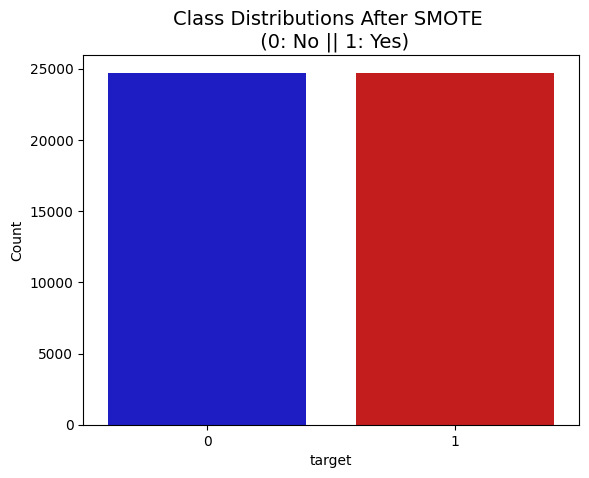

In [122]:
Y_balance.value_counts()

sns.countplot(x=Y_balance, palette=colors)
plt.title('Class Distributions After SMOTE \n (0: No || 1: Yes)', fontsize=14)
plt.xlabel('target')
plt.ylabel('Count')

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

In [124]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [125]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [126]:
#huấn luyện + đánh giá model ban đầu với Cross Validation(CV)
from sklearn.model_selection import cross_val_score

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name:20s}: Accuracy = {round(scores.mean() * 100, 2)}%")

Logistic Regression : Accuracy = 59.0%
Decision Tree       : Accuracy = 89.96%
Random Forest       : Accuracy = 90.1%
SVM                 : Accuracy = 86.94%
XGBoost             : Accuracy = 87.98%
[LightGBM] [Info] Number of positive: 17298, number of negative: 17298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 34596, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 13838, number of negative: 13838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

In [127]:
#Tìm tham số tối ưu bằng GridSearchCV
from sklearn.model_selection import GridSearchCV


#Logistic Regression
log_reg_params = {"penalty" : ['l1', 'l2'], # Lựa chọn loại regularization
                  'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # Hệ số điều chỉnh độ mạnh của regularization
#tìm tổ hợp tham số tốt nhất cho Logistic Regression
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
#lưu mô hình logistic có tham số tốt nhất
log_reg = grid_log_reg.best_estimator_



# RANDOM FOREST
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "criterion": ["gini", "entropy"]
}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)
rf_clf = grid_rf.best_estimator_


#Support Vector Classifier (SVC)
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],  # Tham số regularization
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']  # Loại kernel để phân chia dữ liệu
}
# Tìm mô hình SVC tốt nhất với các tổ hợp kernel và C
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# Lưu lại mô hình SVC tốt nhất
svc = grid_svc.best_estimator_

# DECISION TREE
# Định nghĩa lưới tham số cho Decision Tree
tree_params = {
    "criterion": ["gini", "entropy"],  # Tiêu chí chia nhánh
    "max_depth": list(range(2, 4, 1)),  # Độ sâu tối đa của cây
    "min_samples_leaf": list(range(5, 7, 1))  # Số mẫu tối thiểu ở một lá (leaf)
}

# Tìm mô hình cây quyết định tốt nhất
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Lưu lại mô hình Decision Tree tốt nhất
tree_clf = grid_tree.best_estimator_

# LIGHTGBM
from lightgbm import LGBMClassifier

lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_train, y_train)
lgbm_clf = grid_lgbm.best_estimator_


# XGBOOST
from xgboost import XGBClassifier

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0), xgb_params)
grid_xgb.fit(X_train, y_train)
xgb_clf = grid_xgb.best_estimator_


# CATBOOST
from catboost import CatBoostClassifier

catboost_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 7]
}

grid_cat = GridSearchCV(CatBoostClassifier(verbose=0), catboost_params)
grid_cat.fit(X_train, y_train)
catboost_clf = grid_cat.best_estimator_

[LightGBM] [Info] Number of positive: 13838, number of negative: 13838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 27676, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [128]:
from sklearn.model_selection import cross_val_score

# Tập hợp tất cả mô hình tốt nhất
best_models = {
    'Logistic Regression': log_reg,
    'SVC': svc,
    'Decision Tree': tree_clf,
    'Random Forest': rf_clf,
    'LightGBM': lgbm_clf,
    'XGBoost': xgb_clf,
    'CatBoost': catboost_clf
}

# Đánh giá từng mô hình bằng 5-fold cross-validation
for name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = round(scores.mean() * 100, 2)
    print(f'{name} Cross Validation Score: {mean_score}%')

Logistic Regression Cross Validation Score: 59.49%
SVC Cross Validation Score: 86.94%
Decision Tree Cross Validation Score: 59.71%
Random Forest Cross Validation Score: 90.13%
[LightGBM] [Info] Number of positive: 13838, number of negative: 13838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 27676, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 13838, number of negative: 13839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

In [129]:
from sklearn.model_selection import cross_val_predict

# Lấy output cho các mô hình – để vẽ ROC hoặc tính AUC
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='decision_function')

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method='decision_function')

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

lgbm_pred = cross_val_predict(lgbm_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

xgb_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

catboost_pred = cross_val_predict(catboost_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]


[LightGBM] [Info] Number of positive: 13838, number of negative: 13838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 27676, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 13838, number of negative: 13839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 27677, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499982 -> initscore=-0.00

In [130]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))
print('LightGBM Classifier: ', roc_auc_score(y_train, lgbm_pred))
print('XGBoost Classifier: ', roc_auc_score(y_train, xgb_pred))
print('CatBoost Classifier: ', roc_auc_score(y_train, catboost_pred))


Logistic Regression:  0.6289131453573662
Support Vector Classifier:  0.9306170669870936
Decision Tree Classifier:  0.6316946832346589
Random Forest Classifier:  0.9651852165332729
LightGBM Classifier:  0.9496858012586584
XGBoost Classifier:  0.953745990201938
CatBoost Classifier:  0.9587878020673991


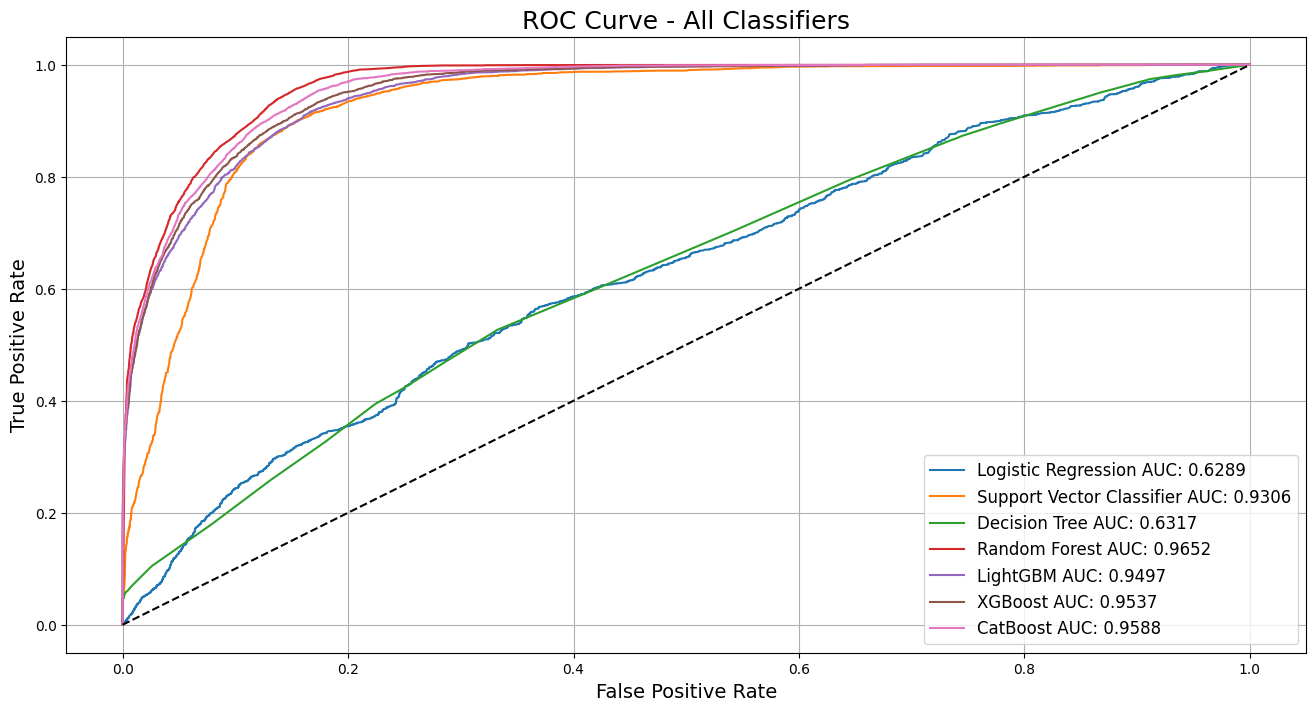

In [132]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Tính fpr, tpr cho từng mô hình
log_fpr, log_tpr, _ = roc_curve(y_train, log_reg_pred)
svc_fpr, svc_tpr, _ = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, _ = roc_curve(y_train, tree_pred)
rf_fpr, rf_tpr, _ = roc_curve(y_train, rf_pred)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_train, lgbm_pred)
xgb_fpr, xgb_tpr, _ = roc_curve(y_train, xgb_pred)
cat_fpr, cat_tpr, _ = roc_curve(y_train, catboost_pred)

def graph_roc_curve_multiple(models_roc_data):
    plt.figure(figsize=(16, 8))
    plt.title('ROC Curve - All Classifiers', fontsize=18)

    # Vẽ từng đường ROC
    for model_name, (fpr, tpr, y_score) in models_roc_data.items():
        auc_score = roc_auc_score(y_train, y_score)
        plt.plot(fpr, tpr, label=f'{model_name} AUC: {auc_score:.4f}')

    # Đường baseline
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
models_roc_data = {
    'Logistic Regression': (log_fpr, log_tpr, log_reg_pred),
    'Support Vector Classifier': (svc_fpr, svc_tpr, svc_pred),
    'Decision Tree': (tree_fpr, tree_tpr, tree_pred),
    'Random Forest': (rf_fpr, rf_tpr, rf_pred),
    'LightGBM': (lgbm_fpr, lgbm_tpr, lgbm_pred),
    'XGBoost': (xgb_fpr, xgb_tpr, xgb_pred),
    'CatBoost': (cat_fpr, cat_tpr, catboost_pred)
}

graph_roc_curve_multiple(models_roc_data)


In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def evaluate_model(name, y_true, y_pred, y_proba):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

In [134]:
results = []

# Logistic Regression
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]
results.append(evaluate_model('Logistic Regression', y_test, y_pred, y_proba))

# SVC
y_pred = svc.predict(X_test)
y_proba = svc.decision_function(X_test)  # SVC không có predict_proba mặc định
results.append(evaluate_model('SVC', y_test, y_pred, y_proba))

# Decision Tree
y_pred = tree_clf.predict(X_test)
y_proba = tree_clf.predict_proba(X_test)[:,1]
results.append(evaluate_model('Decision Tree', y_test, y_pred, y_proba))

# Random Forest
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:,1]
results.append(evaluate_model('Random Forest', y_test, y_pred, y_proba))

# LightGBM
y_pred = lgbm_clf.predict(X_test)
y_proba = lgbm_clf.predict_proba(X_test)[:,1]
results.append(evaluate_model('LightGBM', y_test, y_pred, y_proba))

# XGBoost
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:,1]
results.append(evaluate_model('XGBoost', y_test, y_pred, y_proba))

# CatBoost
y_pred = catboost_clf.predict(X_test)
y_proba = catboost_clf.predict_proba(X_test)[:,1]
results.append(evaluate_model('CatBoost', y_test, y_pred, y_proba))


In [135]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='ROC AUC', ascending=False)
print(df_results)


                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
3        Random Forest  0.901538   0.865725  0.950499  0.906133  0.966248
6             CatBoost  0.889871   0.869582  0.917319  0.892813  0.959558
5              XGBoost  0.878810   0.858456  0.907203  0.882156  0.952517
4             LightGBM  0.875843   0.854562  0.905854  0.879460  0.948508
1                  SVC  0.876989   0.845147  0.923118  0.882414  0.933571
0  Logistic Regression  0.606285   0.610395  0.587672  0.598818  0.634716
2        Decision Tree  0.594888   0.626825  0.468978  0.536533  0.634482
